In [11]:
import torch
from components import NeuralProcess
from metalearning_benchmarks.sinusoid1d_benchmark import Sinusoid1D
from train_val import train_and_validate
from utils import DataModule, MetaLearningDataset, split_context_target
from matplotlib import pyplot as plt

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [5]:
benchmark = Sinusoid1D(
    n_task=4096,
    n_datapoints_per_task=128,
    output_noise=0.01,
    seed_task=1235, 
    seed_x=123, 
    seed_noise=1237
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=128,
    dataset_and_split=(dataset, (0.8, 0.2)),
)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 201542.31it/s]


In [7]:
model = NeuralProcess(
    x_dim=1, 
    y_dim=1, 
    r_dim=16, 
    z_dim=16, 
    h_dim=128, 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [8]:
avg_train_recon_losses = []
avg_train_kl_divs = []

avg_val_recon_losses = []
avg_val_kl_divs = []

In [13]:
losses = train_and_validate(
    model=model,
    data_module=data_module,
    num_epochs=120,
    device=device,
    optimizer=optimizer,
)

avg_train_recon_losses.extend(losses[0])
avg_train_kl_divs.extend(losses[1])

avg_val_recon_losses.extend(losses[2])
avg_val_kl_divs.extend(losses[3])

100%|██████████| 7/7 [00:00<00:00, 15.06it/s, epoch=59, kl_div=1.05, loss=-1.58, recon_loss=-2.63] 


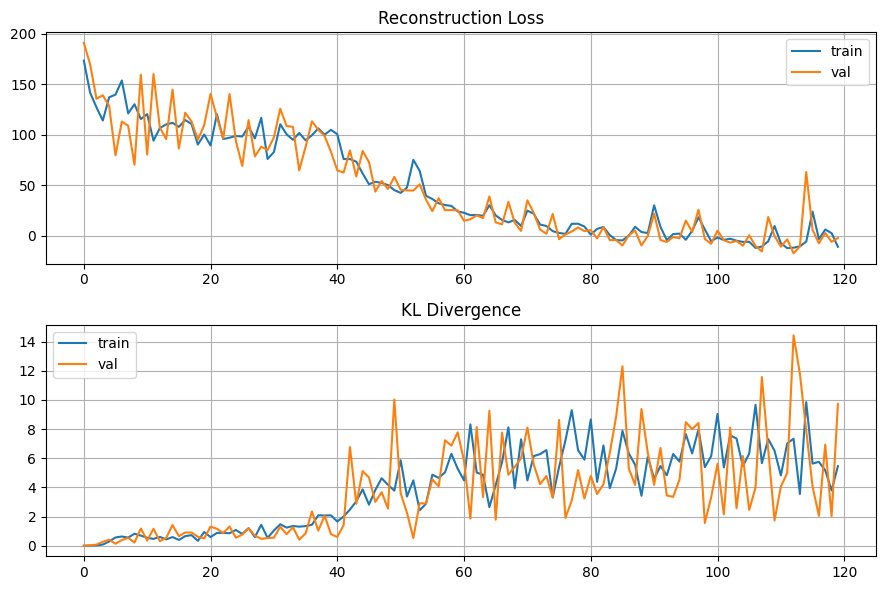

In [14]:
_, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(avg_train_recon_losses, label="train")
ax[0].plot(avg_val_recon_losses, label="val")
ax[0].set_title("Reconstruction Loss")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_kl_divs, label="train")
ax[1].plot(avg_val_kl_divs, label="val")
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

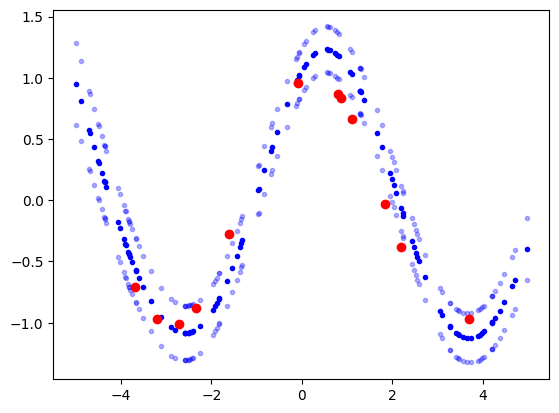

In [123]:
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)

x_data, y_data = next(iter(gen_dataloader))
x_data, y_data = x_data.to(device), y_data.to(device)

factor = 0.1
x_context, y_context, x_target, y_target = split_context_target(x_data, y_data, factor, random=False)

n_samples = 1

mus, logvars, _, _ = model.sample(x_context, y_context, x_target, n_samples)

for i in range(n_samples):
    plt.scatter(x_target.cpu().detach().numpy(), mus[i].cpu().detach().numpy(), marker=".", c="blue")
    plt.scatter(
        x_target.cpu().detach().numpy(), 
        (mus[i] - 2*torch.exp(0.5 * logvars[i])).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )
    plt.scatter(
        x_target.cpu().detach().numpy(), 
        (mus[i] + 2*torch.exp(0.5 * logvars[i])).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )

plt.scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="o", c="red")

plt.show()